In [12]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [13]:
import pathlib
import sys
PATH = pathlib.Path().absolute().resolve()

In [14]:
%matplotlib inline
import math
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.ticker as tk
import seaborn as sns
from scipy.signal import savgol_filter

sns.set(style="whitegrid", font_scale=1.4)
COLORS = sns.color_palette()

In [15]:
from genetic import vars
vars.DB = "genetic_remote.db"
from genetic.db_connection import SqlEngine, Session
from genetic.models import BotInstance
from genetic.bot_model import BotArguments as BotArgumentsCurrent
from bot.utils import disable_print
BotArguments = BotArgumentsCurrent()

from sqlalchemy import orm
import sqlalchemy as sql
import operator
from collections import defaultdict
import statistics

In [16]:
max_games = Session.query(sql.func.max(BotInstance.game4_count)).one()[0]
bots = list(Session.query(BotInstance).filter_by(game4_count=max_games))
last_generation = list(Session.query(BotInstance).filter_by(generation=Session.query(sql.func.max(BotInstance.generation))))
Halite = Session.query(BotInstance.generation, sql.func.sum(BotInstance.halite))\
    .filter_by(game4_count=max_games)\
    .group_by(BotInstance.generation)\
    .all()
Halite = {g: h for g, h in Halite}
Halite = np.fromiter([Halite[i] for i in range(max(Halite.keys()) + 1)], dtype=np.double)

In [17]:
from genetic.core import GeneticOptimizer, GeneticOptimizerCore
GeneticOptimizer(GeneticOptimizerCore(BotArguments)).print()

       distance_penalty_k | 0.575 +-0.49121 (weighted: 0.866)
enemy_ship_nearby_penalty | 0.687 +-0.24772 (weighted: 0.653)
       enemy_ship_penalty | 0.368 +-0.12068 (weighted: 0.392)
      same_target_penalty | 0.486 +-0.27929 (weighted: 0.463)
              ship_fill_k | 0.461 +-0.23345 (weighted: 0.514)
               ship_limit | 49.562 +-18.54887 (weighted: 51.096)
       ship_limit_scaling | 0.912 +-0.23492 (weighted: 0.902)
     ship_spawn_stop_turn | 0.403 +-0.10485 (weighted: 0.372)
--------------------------------------------------
0) 20.48kk
1) 22.48kk
2) 21.49kk
3) 17.14kk
4) 6.82kk


In [18]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

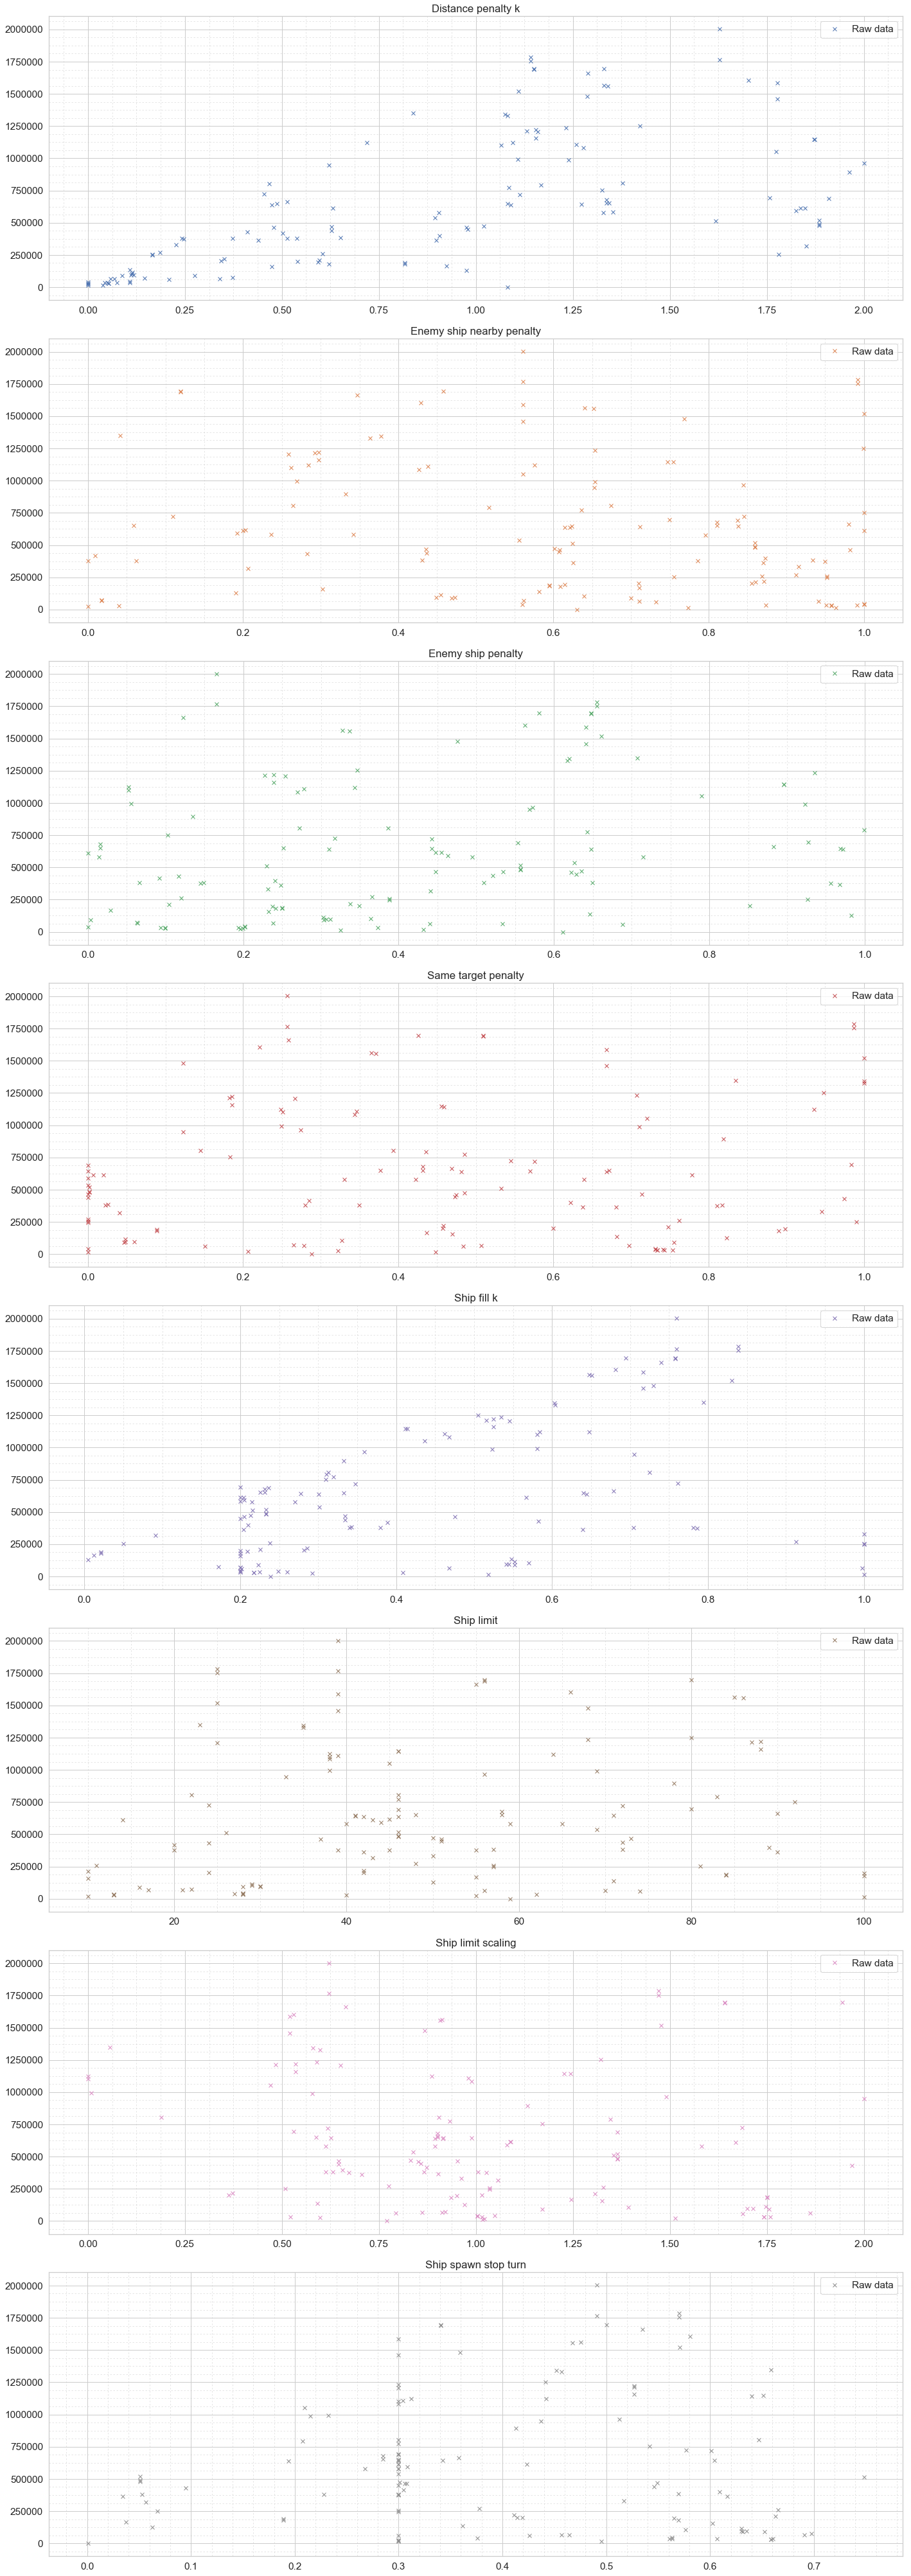

In [19]:
names = [name for name, _ in BotArguments]
data = bots

fig = plt.figure(figsize=(20, 7 * len(names)))
for i, name in enumerate(names):
    ax = fig.add_subplot(len(names) * 100 + 10 + i + 1)
    X, Y = [bot.args_dict[name] for bot in data], [bot.halite for bot in data]
    X, Y = zip(*sorted(zip(X, Y), key=operator.itemgetter(0)))
    X, Y = np.fromiter(X, dtype=float), np.fromiter(Y, dtype=float)
    ax.plot(X, Y, '.' if len(X) > 250 else 'x', alpha=.5  if len(X) > 250 else 1, color=COLORS[i % len(COLORS)], label='Raw data')
    
    if len(X) > 250:
        with disable_print():
            Y_smooth = savgol_filter(Y, 201, 3)
        ax.plot(X, Y_smooth, linewidth=3, color=COLORS[i % len(COLORS)], label="Savgol filter")

        Y_ma = moving_average(Y, n=10)
        n_diff = len(X) - len(Y_ma)
        X_ma = X[n_diff//2:-n_diff + n_diff//2]
        ax.plot(X_ma, Y_ma, color=COLORS[i % len(COLORS)], alpha=.5, label="Moving average")
    
        with disable_print():
            Y_ma_smooth = savgol_filter(Y_ma, min(201, len(X) // 10) | 1, min(201, len(X) // 10) - 1)
        ax.plot(X_ma, Y_ma_smooth, linewidth=3, linestyle='--', color=COLORS[i % len(COLORS)], 
                label="Savgol filter (moving average)")
    
    ax.set_title(name.replace("_", " ").capitalize())    
    ax.grid(which='minor', axis='x', dashes=(5, 5), linewidth=.5)
    ax.grid(which='minor', axis='y', dashes=(5, 5), linewidth=.5)
    ax.legend()
    ax.minorticks_on()
    
fig.tight_layout()
plt.show()

In [20]:
max_halite = Y.max()

In [21]:
first = operator.itemgetter(0)
second = operator.itemgetter(1)

def bots_args_stats(bots, arg_name):
    data = defaultdict(list)
    for bot in bots:
        data[bot.generation].append((bot.args_dict[arg_name], bot.halite))
    numpy_data = [np.fromiter(map(first, x), dtype=float) for x in data.values()]
    meta = getattr(BotArguments, arg_name)
    numpy_norm_data = [(x - meta.min) / (meta.max - meta.min) for x in numpy_data]
    return [
        (min(x), np.average(x, weights=[second(y) for y in data[i]]), max(x))
        for i, x in enumerate(numpy_norm_data)
    ]

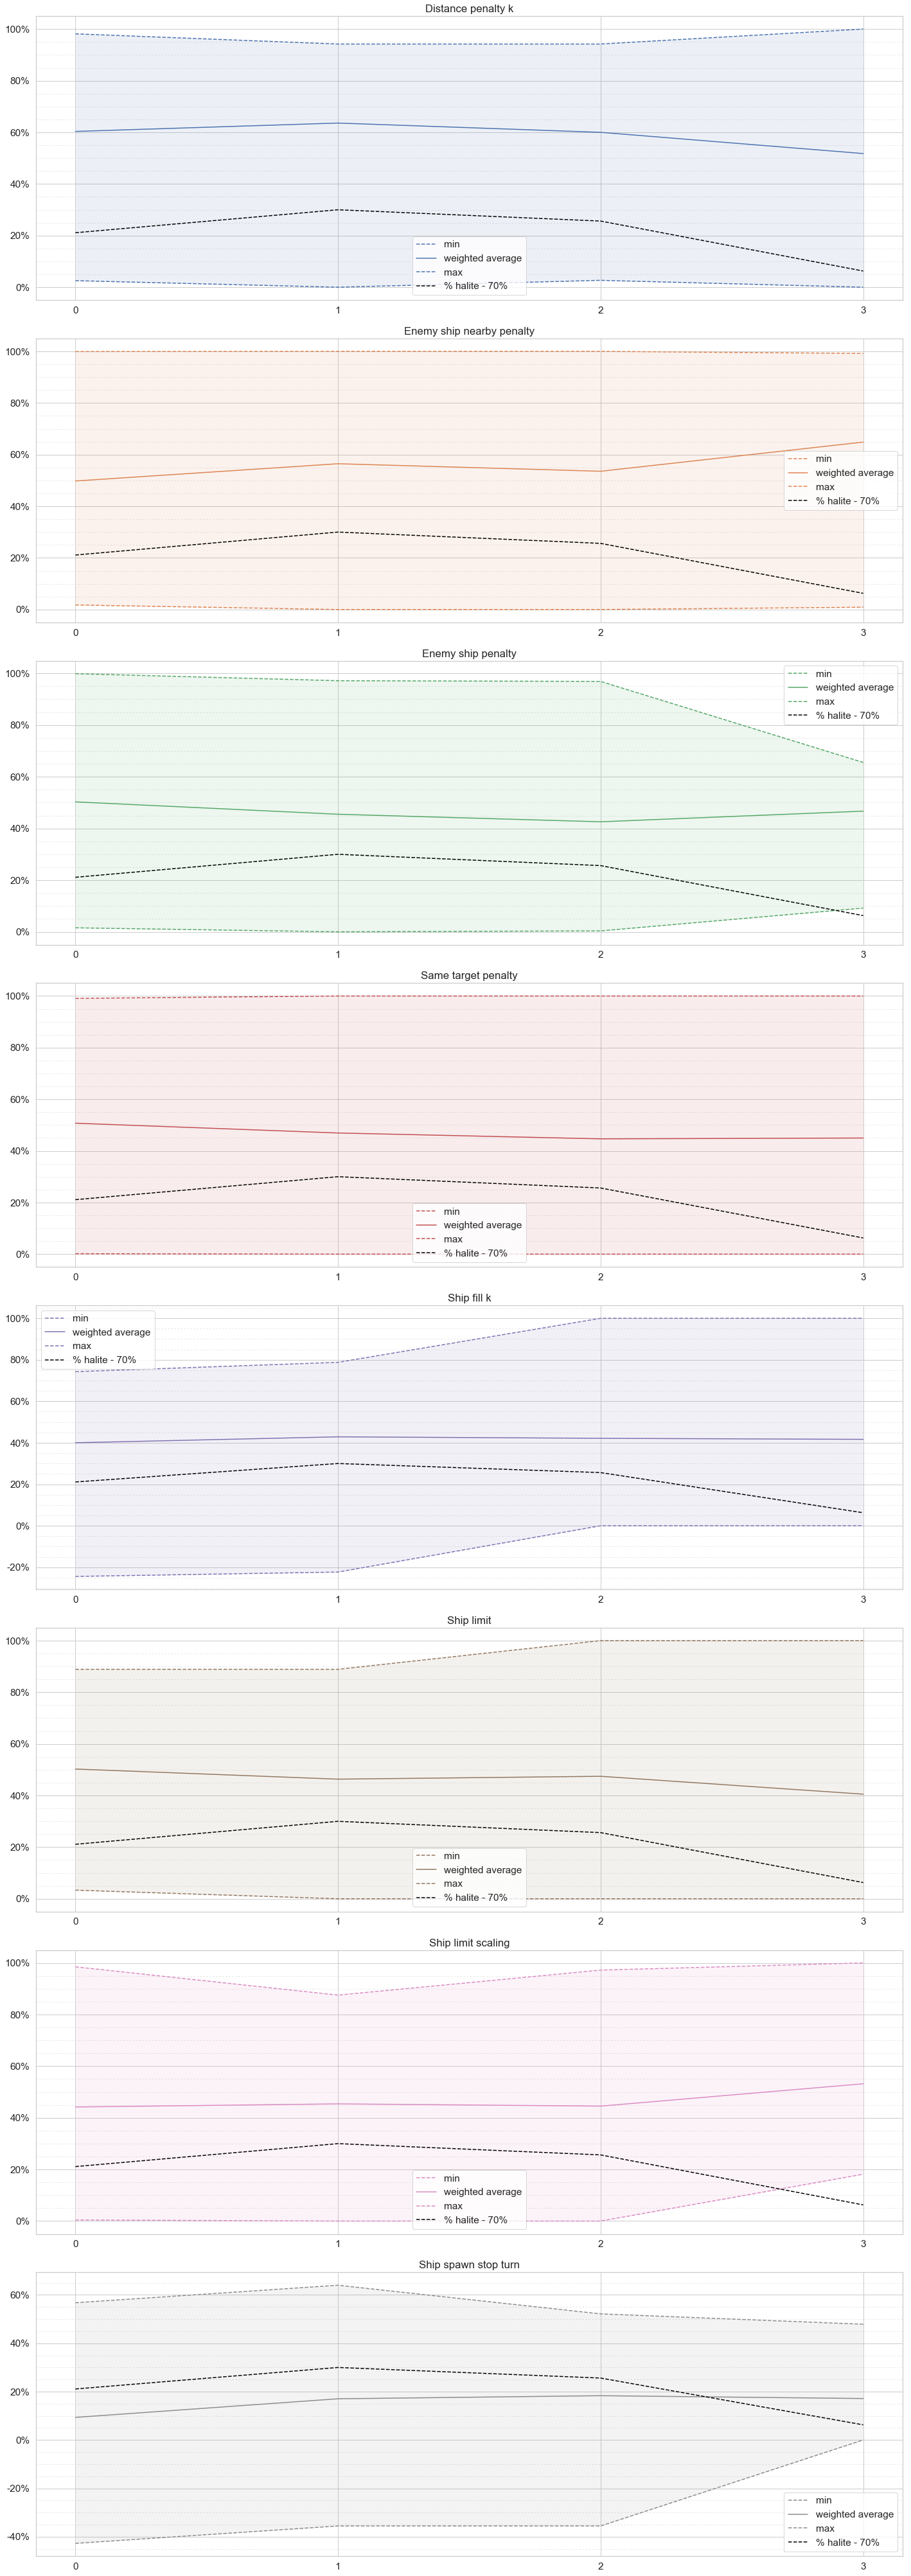

In [22]:
X = np.arange(
    Session.query(sql.func.min(BotInstance.generation)).one()[0], 
    Session.query(sql.func.max(BotInstance.generation)).filter_by(game4_count=max_games).one()[0] + 1
)

fig = plt.figure(figsize=(20, 7 * len(names)))
for i, name in enumerate(names):
    ax = fig.add_subplot(len(names) * 100 + 10 + i + 1)
    Y_min, Y_mean, Y_max = [np.fromiter(it, dtype=float) for it in zip(*bots_args_stats(bots, name))]
    ax.fill_between(X, Y_min, Y_max, facecolor=COLORS[i % len(COLORS)], alpha=.1)
    ax.plot(X, Y_min, linestyle='--', color=COLORS[i % len(COLORS)], label="min")
    ax.plot(X, Y_mean, color=COLORS[i % len(COLORS)], label="weighted average")
    ax.plot(X, Y_max, linestyle='--', color=COLORS[i % len(COLORS)], label="max")
    ax.plot(X, Halite / Halite.max() - .7, linestyle='--', color='black', label='% halite - 70%')
    ax.set_title(name.replace("_", " ").capitalize())
    ax.legend()
    
    ax.grid(which='minor', axis='y', dashes=(5, 5), linewidth=.5)
    ax.minorticks_on()
    ax.xaxis.set_major_locator(tk.MaxNLocator(integer=True))
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

fig.tight_layout()
plt.show()